In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet18_cbam_eca/pytorch/default/1/best_model.pth
/kaggle/input/psfhsp-classification/denoised/denoised/Standard_plane/20191115T105730_719.png
/kaggle/input/psfhsp-classification/denoised/denoised/Non-standard_plane/20191220T102712_59.png
/kaggle/input/psfhsp-classification/2.Thesis_12k/2.Thesis_12k/Standard_plane/01413PSFHSAoP4k_1413.png
/kaggle/input/psfhsp-classification/2.Thesis_12k/2.Thesis_12k/Non-standard_plane/20191220T102712_59.png
/kaggle/input/resnet18_cbam_eca_69epoch/pytorch/default/1/best_model.pth


In [2]:
# import os
# from PIL import Image

# test_root_dir = '/kaggle/input/psfhsp-classification/2.Thesis_12k/2.Thesis_12k/Standard_plane'

# # Get all image file paths in the directory
# image_files = [os.path.join(test_root_dir, f) for f in os.listdir(test_root_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

# # Iterate over each image and get its size
# cnt_test_std = 0
# cnt_test_nonstd = 0
# cnt_train_std = 0
# cnt_train_nonstd = 0
# for image_path in image_files:
#     try:
#         with Image.open(image_path) as img:
#             width, height = img.size
#             cnt_test_std+=1
#             # print(f"Image: {os.path.basename(image_path)}, Size: {width}x{height}")
#     except Exception as e:
#         print(f"Could not process {image_path}: {e}")

# print(cnt_test_std)



# test_root_dir = '/kaggle/input/psfhsp-classification/2.Thesis_12k/2.Thesis_12k/Non-standard_plane'

# # Get all image file paths in the directory
# image_files = [os.path.join(test_root_dir, f) for f in os.listdir(test_root_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

# for image_path in image_files:
#     try:
#         with Image.open(image_path) as img:
#             width, height = img.size
#             cnt_test_nonstd+=1
#             # print(f"Image: {os.path.basename(image_path)}, Size: {width}x{height}")
#     except Exception as e:
#         print(f"Could not process {image_path}: {e}")

# print(cnt_test_nonstd)


# test_root_dir = '/kaggle/input/psfhsp-classification/denoised/denoised/Standard_plane'

# # Get all image file paths in the directory
# image_files = [os.path.join(test_root_dir, f) for f in os.listdir(test_root_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

# for image_path in image_files:
#     try:
#         with Image.open(image_path) as img:
#             width, height = img.size
#             cnt_train_std+=1
#             # print(f"Image: {os.path.basename(image_path)}, Size: {width}x{height}")
#     except Exception as e:
#         print(f"Could not process {image_path}: {e}")

# print(cnt_train_std)


# test_root_dir = '/kaggle/input/psfhsp-classification/denoised/denoised/Non-standard_plane'

# # Get all image file paths in the directory
# image_files = [os.path.join(test_root_dir, f) for f in os.listdir(test_root_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

# for image_path in image_files:
#     try:
#         with Image.open(image_path) as img:
#             width, height = img.size
#             cnt_train_nonstd+=1
#             # print(f"Image: {os.path.basename(image_path)}, Size: {width}x{height}")
#     except Exception as e:
#         print(f"Could not process {image_path}: {e}")

# print(cnt_train_nonstd)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

# ------------------------- ECA Implementation -------------------------

class eca_layer(nn.Module):
    """Constructs a ECA module.

    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
    """
    def __init__(self, channel, k_size=3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x)

# ------------------------- CBAM Implementation -------------------------
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = F.adaptive_avg_pool2d(x, 1)
                channel_att_raw = self.mlp(avg_pool.squeeze(-1).squeeze(-1))
            elif pool_type == 'max':
                max_pool = F.adaptive_max_pool2d(x, 1)
                channel_att_raw = self.mlp(max_pool.squeeze(-1).squeeze(-1))

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum += channel_att_raw

        scale = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False)

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # Applying sigmoid instead of softmax for binary activation
        return x * scale

class CBAM_ECA(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(CBAM_ECA, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.SpatialGate = SpatialGate()
        self.eca_layer = eca_layer(gate_channels)

    def forward(self, x):
        x_out = self.ChannelGate(x)
        x_out = self.SpatialGate(x_out)
        x_out = self.eca_layer(x_out)
        return x_out

# ------------------------- ResNet18 with CBAM_ECA (Excluding Last Layer) -------------------------

class Block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1, use_cbam_eca=True):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.identity_downsample = identity_downsample
        self.use_cbam_eca = use_cbam_eca
        if use_cbam_eca:
            self.cbam = CBAM_ECA(intermediate_channels)  # Add CBAM only if enabled

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        if self.use_cbam_eca:
            x = self.cbam(x)  # Apply CBAM if enabled
        x = self.relu(x)
        return x

class ResNet_CBAM_ECA(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet_CBAM_ECA, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1, use_cbam_eca=True)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2, use_cbam_eca=True)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2, use_cbam_eca=True)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2, use_cbam_eca=False)  # No CBAM in last layer

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)  # Last layer without CBAM

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return nn.functional.softmax(x, dim=1)

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride, use_cbam_eca):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, intermediate_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(intermediate_channels)
            )

        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride, use_cbam_eca=use_cbam_eca))
        self.in_channels = intermediate_channels

        for _ in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels, use_cbam_eca=use_cbam_eca))

        return nn.Sequential(*layers)

def ResNet18_CBAM_ECA():
    img_channel = 3
    num_classes = 2
    return ResNet_CBAM_ECA(Block, [2, 2, 2, 2], img_channel, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_cbam_eca = ResNet18_CBAM_ECA().to(device)  # Move model to device
print(resnet18_cbam_eca)


# Print model summary
from torchsummary import summary
summary(resnet18_cbam_eca, (3, 224, 224), device=str(device))  # Ensure summary uses the correct device

ResNet_CBAM_ECA(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (cbam): CBAM_ECA(
        (ChannelGate): ChannelGate(
          (mlp): Sequential(
            (0): Flatten()
            (1): Linear(in_features=64, out_features=4, bias=True)
            (2): ReLU()
            (3): Linear(in_features=4, out_features=64, bias=

In [4]:
import copy


class EarlyStopping:
    def __init__(self, patience, min_delta=0.01, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None  # Initialize best_model to None
        self.best_loss = float('inf')  # Initialize best_loss to a large value
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        # Check if it's the first epoch or if validation loss improved
        if val_loss < self.best_loss:  # Use '<' to check for improvement
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    if self.best_model is not None:  # Check if best_model exists before loading
                        model.load_state_dict(self.best_model)
                    else:
                        print("Warning: No best model found to restore.")
                return True
        return False

In [5]:
def save_checkpoint_f(model, optimizer, path, epoch, fold, train_acc, val_acc, early_stopping,train_accuracies,val_accuracies,train_f1_scores,
                    val_f1_scores,train_roc_aucs,val_roc_aucs,all_train_loss,all_val_loss,best_acc,fold_train_accuracies,fold_val_accuracies,fold_train_loss,
                    fold_val_loss,fold_train_f1,fold_val_f1,fold_train_roc,fold_val_roc,track_all_train_loss,track_all_val_loss):
    checkpoint = {
        'fold': fold,
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_acc': train_acc,
        'val_acc': val_acc,
        'best_loss': early_stopping.best_loss,
        'counter': early_stopping.counter,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_f1_scores':train_f1_scores,
        'val_f1_scores':val_f1_scores,
        'train_roc_aucs':train_roc_aucs,
        'val_roc_aucs':val_roc_aucs,
        'all_train_loss':all_train_loss,
        'all_val_loss':all_val_loss,
        'best_acc':best_acc,
        'fold_train_accuracies':fold_train_accuracies,
        'fold_val_accuracies':fold_val_accuracies,
        'fold_train_loss':fold_train_loss,
        'fold_val_loss':fold_val_loss,
        'fold_train_f1':fold_train_f1,
        'fold_val_f1':fold_val_f1,
        'fold_train_roc':fold_train_roc,
        'fold_val_roc':fold_val_roc,
        'track_all_train_loss':track_all_train_loss,
        'track_all_val_loss':track_all_val_loss
    }
    torch.save(checkpoint, path)



def load_checkpoint_f(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_acc = checkpoint['train_acc']
    val_acc = checkpoint['val_acc']
    best_loss = checkpoint.get('best_loss', None)
    counter = checkpoint.get('counter', 0)
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_accuracies = checkpoint.get('val_accuracies', [])
    all_train_loss = checkpoint.get('all_train_loss', [])
    all_val_loss = checkpoint.get('all_val_loss',[])
    train_f1_scores = checkpoint.get('train_f1_scores', [])
    val_f1_scores = checkpoint.get('val_f1_scores', [])
    train_roc_aucs = checkpoint.get('train_roc_aucs', [])
    val_roc_aucs = checkpoint.get('val_roc_aucs', [])
    best_acc = checkpoint['best_acc']
    fold_train_accuracies = checkpoint.get('fold_train_accuracies', [])
    fold_val_accuracies = checkpoint.get('fold_val_accuracies', [])
    fold_train_loss = checkpoint.get('fold_train_loss', [])
    fold_val_loss = checkpoint.get('fold_val_loss', [])
    fold_train_f1 = checkpoint.get('fold_train_f1', [])
    fold_val_f1 = checkpoint.get('fold_val_f1', [])
    fold_train_roc = checkpoint.get('fold_train_roc', [])
    fold_val_roc = checkpoint.get('fold_val_roc', [])
    track_all_train_loss = checkpoint.get('track_all_train_loss', [])
    track_all_val_loss = checkpoint.get('track_all_val_loss', [])


    return (model, optimizer, epoch, train_acc, val_acc, best_loss, counter,train_accuracies, val_accuracies,all_train_loss,all_val_loss,
            train_f1_scores,val_f1_scores,train_roc_aucs,val_roc_aucs,best_acc,fold_train_accuracies,fold_val_accuracies,fold_train_loss,
            fold_val_loss,fold_train_f1,fold_val_f1,fold_train_roc,fold_val_roc,track_all_train_loss,track_all_val_loss)


def load_checkpoint_fold(path):
    checkpoint = torch.load(path)
    fold = checkpoint['fold']
    return fold

In [6]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F

import os
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import random

import warnings
warnings.filterwarnings("ignore")

In [7]:
import os
import torch
import numpy as np
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from collections import Counter

class UltrasoundDataset_f(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Function to handle different dataset structures
def load_dataset_f(root_dir):
    image_paths = []
    labels = []

    for class_label, class_name in enumerate(['Non-standard_plane', 'Standard_plane']):
        class_dir = os.path.join(root_dir, class_name)  # Directly access class folder
        print(f"Checking directory: {class_dir}")  # Debugging print

        if os.path.exists(class_dir) and os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):  # Ensure it's an image file
                    image_paths.append(img_path)
                    labels.append(class_label)

    print(f"Total images found: {len(image_paths)}")  # Debugging print
    return image_paths, labels


    

### **Loading the test dataset**
test_root_dir = '/kaggle/input/psfhsp-classification/2.Thesis_12k/2.Thesis_12k'
test_image_paths, test_labels = load_dataset_f(test_root_dir)

import os
print("Test directory exists:", os.path.exists(test_root_dir))
test_image_paths, test_labels = load_dataset_f(test_root_dir)
print(f"Total images found: {len(test_image_paths)}")
print(f"Total labels found: {len(test_labels)}")
print(f"Unique labels: {set(test_labels)}")


# Splitting test data (keeping validation + test set separate)
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    test_image_paths, test_labels, test_size=1/6, stratify=test_labels, random_state=42
)

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function early in the script
set_seed(42)

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Creating test dataset
test_dataset_f = UltrasoundDataset_f(test_image_paths, test_labels, transform=test_transform)
print(f"Test dataset size: {len(test_dataset_f)}")

Checking directory: /kaggle/input/psfhsp-classification/2.Thesis_12k/2.Thesis_12k/Non-standard_plane
Checking directory: /kaggle/input/psfhsp-classification/2.Thesis_12k/2.Thesis_12k/Standard_plane
Total images found: 12581
Test directory exists: True
Checking directory: /kaggle/input/psfhsp-classification/2.Thesis_12k/2.Thesis_12k/Non-standard_plane
Checking directory: /kaggle/input/psfhsp-classification/2.Thesis_12k/2.Thesis_12k/Standard_plane
Total images found: 12581
Total images found: 12581
Total labels found: 12581
Unique labels: {0, 1}
Test dataset size: 2097


In [8]:

# Print class distribution in test dataset
test_class_counts = Counter(test_labels)
for class_label, count in test_class_counts.items():
    print(f"Test Class {class_label}: {count} images")


Test Class 1: 1517 images
Test Class 0: 580 images


In [9]:
# Function to load image paths and labels from class folders
def load_dataset_training(root_dir):
    image_paths = []
    labels = []

    for class_label, class_name in enumerate(['Non-standard_plane','Standard_plane']):
        class_dir = os.path.join(root_dir, class_name)
        for img_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(class_label)

    return image_paths, labels
    
### **Loading the train dataset**
train_root_dir = '/kaggle/input/psfhsp-classification/denoised/denoised'
train_image_paths, train_labels = load_dataset_training(train_root_dir)

# Creating train dataset
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset_f = UltrasoundDataset_f(train_image_paths, train_labels, transform=train_transform)
print(f"Train dataset size: {len(train_dataset_f)}")

# Print class distribution in train dataset
train_class_counts = Counter(train_labels)
for class_label, count in train_class_counts.items():
    print(f"Train Class {class_label}: {count} images")


Train dataset size: 15168
Train Class 0: 7584 images
Train Class 1: 7584 images


TRAINING

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import random
from sklearn.model_selection import StratifiedKFold

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = ResNet18_CBAM_ECA().to(device)


# Set Kaggle directories for working and output storage
working_dir = '/kaggle/working'
output_dir = '/kaggle/output'

# Create directories for working storage
save_dir = os.path.join(working_dir, 'resnet18_cbam_eca/model')
checkpoint_dir = os.path.join(working_dir, 'checkpoints_resnet18')

# Create directories for output storage
output_save_dir = os.path.join(output_dir, 'resnet18_cbam_eca/model')
output_checkpoint_dir = os.path.join(output_dir, 'checkpoints_resnet18')

# Ensure all directories exist
os.makedirs(save_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(output_save_dir, exist_ok=True)
os.makedirs(output_checkpoint_dir, exist_ok=True)

best_model_path = os.path.join(save_dir, 'best_model.pth')
output_best_model_path = os.path.join(output_save_dir, 'best_model.pth')


# Check if any checkpoint file exists in the directory
load_PATH = "/kaggle/input/resnet_cbam_eca_70epoch/pytorch/default/1/checkpoint_epoch.pth"
print(os.path.exists(load_PATH))



print("Training and evaluation")



skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)


model = net.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 200
train_loss = []
validation_loss = []

patience = 20
early_stopping = EarlyStopping(patience=patience)
early_stop = False

if os.path.exists(load_PATH):
    print("Loading model...")
    (model, optimizer, start_epoch, train_acc, val_acc, best_loss, counter,train_accuracies, val_accuracies,all_train_loss,all_val_loss,train_f1_scores,
     val_f1_scores,train_roc_aucs,val_roc_aucs,best_acc,fold_train_accuracies,fold_val_accuracies,fold_train_loss,
     fold_val_loss,fold_train_f1,fold_val_f1,fold_train_roc,fold_val_roc,track_all_train_loss,track_all_val_loss) = load_checkpoint_f(model, optimizer, load_PATH)

    early_stopping.best_loss = best_loss
    early_stopping.counter = counter
    best_model_wts = model.state_dict()

    if (start_epoch+1)% 5 == 0 :
        train_accuracies = []
        val_accuracies = []
        train_f1_scores = []
        val_f1_scores = []
        train_roc_aucs = []
        val_roc_aucs = []
        all_train_loss = []
        all_val_loss = []

    print("train_accuracies: ",train_accuracies)
    print("val_accuracies: ",val_accuracies)
    print("train_f1_scores: ",train_f1_scores)
    print("val_f1_scores: ",val_f1_scores)
    print('train_roc_aucs: ',train_roc_aucs)
    print('val_roc_aucs: ',val_roc_aucs)
    print('all_train_loss: ',all_train_loss)
    print('all_val_loss: ',all_val_loss)
    print("best_acc: ",best_acc)
    print("fold_train_accuracies: ",fold_train_accuracies)
    print("fold_val_accuracies: ",fold_val_accuracies)
    print("fold_train_loss: ",fold_train_loss)
    print("fold_val_loss: ",fold_val_loss)
    print("fold_train_f1: ",fold_train_f1)
    print("fold_val_f1: ",fold_val_f1)
    print("fold_train_roc: ",fold_train_roc)
    print("fold_val_roc: ",fold_val_roc)
    print("---------------------------------------------------------------------")
    # print("mean(val_loss): ",np.mean(all_val_loss))
    print(f"Model loaded from epoch {start_epoch + 1} with best_loss: {best_loss} and counter: {counter}")
    print(f"Train accuracy: {train_acc}, Validation accuracy: {val_acc}")
    load_model = False
    start_epoch += 1
else:
    print("No model to load.")
    fold_train_loss = []
    fold_val_loss = []
    fold_train_accuracies = []
    fold_val_accuracies = []
    fold_train_f1 = []
    fold_val_f1 = []
    fold_train_roc = []
    fold_val_roc = []
    track_all_train_loss = []
    track_all_val_loss = []

    train_accuracies = []
    val_accuracies = []
    train_f1_scores = []
    val_f1_scores = []
    train_roc_aucs = []
    val_roc_aucs = []
    all_train_loss = []
    all_val_loss = []
    best_acc = 0.0
    best_loss = 1e5
    best_f1 = 0.0
    best_model_wts = 0
    start_epoch = 0
    fold = 0


train_loaders = []
val_loaders = []

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set the seed globally
set_seed(42)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_dataset_f.image_paths, train_dataset_f.labels)):
  # Define the data loaders for the current fold
  train_loader = DataLoader(
      dataset=train_dataset_f,
      batch_size=64,
      worker_init_fn=lambda _: np.random.seed(42),
      sampler=torch.utils.data.SubsetRandomSampler(train_idx),
  )
  val_loader = DataLoader(
      dataset=train_dataset_f,
      batch_size=64,
      sampler=torch.utils.data.SubsetRandomSampler(val_idx),
  )

  train_loaders.append(train_loader)
  val_loaders.append(val_loader)

  print(f"Fold {fold + 1}:")
  print(f"Train_loader: {len(train_loaders[fold])}")
  print(f"Val_loader: {len(val_loaders[fold])}")

  if (fold+1) % 5 == 0:
      break

# print size of train_loaders
print(len(train_loaders))
print(len(val_loaders))

for epoch in range(start_epoch,num_epochs):

    # if (counter == 20):
    #     break
    
    
    print("---------------------EPOCH---------------------------- ",epoch+1)
    fold = epoch%5
    print(f"Fold {fold + 1}")
    print("-------")

    model.train()
    running_loss = 0.0
    loss = 0.0
    correct = 0
    true = []
    pre = []
    proba = []
    train_loss = []

    for images,labels in train_loaders[fold]:

        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # running_loss += loss.item()
        train_loss.append(loss.item())
        pred = outputs.argmax(dim=1, keepdim=True)
        true.extend(labels.cpu().numpy())
        pre.extend(pred.cpu().numpy())
        train_probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
        proba.extend(train_probs.detach().cpu().numpy())
        # correct += pred.eq(labels.view_as(pred)).sum().item()


    all_train_loss.append(np.mean(train_loss))
    track_all_train_loss.append(np.mean(train_loss))
    train_accuracy = accuracy_score(true,pre)
    train_accuracies.append(train_accuracy)
    train_f1 = f1_score(true,pre)
    train_f1_scores.append(train_f1)
    train_roc = roc_auc_score(true,proba)
    train_roc_aucs.append(train_roc)

    print(f"Epoch [{epoch+1}/{num_epochs}],Train Loss: {np.mean(train_loss):.4f}, Train Accuracy: {train_accuracy}, Train F1: {train_f1}, train roc: {train_roc}")



    # val the model
    model.eval()
    running_loss = 0.0
    correct = 0
    val_loss = []


    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        val_true = []
        val_pre = []
        val_proba = []
        val_loss = []
        for val_images, val_labels in val_loaders[fold]:

            outputs = model(val_images.to(device))
            loss = criterion(outputs, val_labels.to(device))
            running_loss += loss.item()
            val_loss.append(loss.item())

            pred = outputs.argmax(dim=1, keepdim=True)
            val_true.extend(val_labels.cpu().numpy())
            val_pre.extend(pred.cpu().numpy())
            val_probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
            val_proba.extend(val_probs.detach().cpu().numpy())
            # correct += pred.eq(labels.view_as(pred)).sum().item()


        all_val_loss.append(np.mean(val_loss))
        track_all_val_loss.append(np.mean(val_loss))
        val_accuracy = accuracy_score(val_true,val_pre)
        val_accuracies.append(val_accuracy)
        val_f1 = f1_score(val_true,val_pre)
        val_f1_scores.append(val_f1)
        val_roc = roc_auc_score(val_true,val_proba)
        val_roc_aucs.append(val_roc)

        print(f"Epoch [{epoch+1}/{num_epochs}],Val Loss: {np.mean(val_loss):.4f} , Val Accuracy: {val_accuracy}, Val F1: {val_f1}, val roc: {val_roc}")



        if np.mean(val_loss) < best_loss:
                best_acc = val_accuracy
                best_loss = np.mean(val_loss)
                #Save the best model
                best_model_wts = model.state_dict()
                torch.save(best_model_wts, best_model_path)  # Save in working dir
                torch.save(best_model_wts, output_best_model_path)  # Save in output dir
                print("The best weight is: ",fold)
                print(f"New best model saved with validation accuracy: {best_acc:.4f} and validation loss: {best_loss:.4f}")


        optimizer.param_groups[0]['lr'] *= 0.9
        early_stop = early_stopping(model, np.mean(val_loss))
        print(early_stopping.status)

        if early_stop:
          print(f"Early stopping at epoch {epoch + 1}")
          break

        print("-------------------------------- Fold train accuracy: ",fold_train_accuracies)

        if (fold+1)% 5 != 0:
            # Save checkpoint
            checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_epoch.pth')
            output_checkpoint_path = os.path.join(output_checkpoint_dir, 'checkpoint_epoch.pth')

            save_checkpoint_f(model, optimizer, checkpoint_path, epoch, fold, train_acc=train_accuracy, val_acc=val_accuracy,
                              early_stopping=early_stopping,train_accuracies=train_accuracies, val_accuracies=val_accuracies,train_f1_scores=train_f1_scores, val_f1_scores=val_f1_scores,
                              train_roc_aucs=train_roc_aucs,val_roc_aucs=val_roc_aucs,all_train_loss=all_train_loss,all_val_loss=all_val_loss,best_acc=best_acc,
                              fold_train_accuracies=fold_train_accuracies,fold_val_accuracies=fold_val_accuracies,fold_train_loss=fold_train_loss,fold_val_loss=fold_val_loss,
                              fold_train_f1=fold_train_f1,fold_val_f1=fold_val_f1,fold_train_roc=fold_train_roc,fold_val_roc=fold_val_roc,track_all_train_loss=track_all_train_loss,
                              track_all_val_loss=track_all_val_loss)
            save_checkpoint_f(model, optimizer, output_checkpoint_path, epoch, fold, train_acc=train_accuracy, val_acc=val_accuracy,
                              early_stopping=early_stopping,train_accuracies=train_accuracies, val_accuracies=val_accuracies,train_f1_scores=train_f1_scores, val_f1_scores=val_f1_scores,
                              train_roc_aucs=train_roc_aucs,val_roc_aucs=val_roc_aucs,all_train_loss=all_train_loss,all_val_loss=all_val_loss,best_acc=best_acc,
                              fold_train_accuracies=fold_train_accuracies,fold_val_accuracies=fold_val_accuracies,fold_train_loss=fold_train_loss,fold_val_loss=fold_val_loss,
                              fold_train_f1=fold_train_f1,fold_val_f1=fold_val_f1,fold_train_roc=fold_train_roc,fold_val_roc=fold_val_roc,track_all_train_loss=track_all_train_loss,
                              track_all_val_loss=track_all_val_loss)

            print(f"Checkpoint saved at epoch {epoch + 1}")



    if (fold+1) % 5 == 0:
      print("-----------------fold5--------------------------------")
      fold_train_loss.append(np.mean(all_train_loss))
      fold_val_loss.append(np.mean(all_val_loss))
      fold_train_accuracies.append(np.mean(train_accuracies))
      fold_val_accuracies.append(np.mean(val_accuracies))
      fold_train_f1.append(np.mean(train_f1_scores))
      fold_val_f1.append(np.mean(val_f1_scores))
      fold_train_roc.append(np.mean(train_roc_aucs))
      fold_val_roc.append(np.mean(val_roc_aucs))

      print("all_train_loss: ",all_train_loss)
      print("fold_train_loss: ",fold_train_loss)
      print("fold_val_loss: ",fold_val_loss)
      print("fold_train_accuracies: ",fold_train_accuracies)
      print("fold_val_accuracies: ",fold_val_accuracies)
      print("fold_train_f1: ",fold_train_f1)
      print("fold_val_f1: ",fold_val_f1)
      print("fold_train_roc: ",fold_train_roc)
      print("fold_val_roc: ",fold_val_roc)

      checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_epoch.pth')
      output_checkpoint_path = os.path.join(output_checkpoint_dir, 'checkpoint_epoch.pth')

      save_checkpoint_f(model, optimizer, checkpoint_path, epoch, fold, train_acc=train_accuracy, val_acc=val_accuracy,
                              early_stopping=early_stopping,train_accuracies=train_accuracies, val_accuracies=val_accuracies,train_f1_scores=train_f1_scores, val_f1_scores=val_f1_scores,
                              train_roc_aucs=train_roc_aucs,val_roc_aucs=val_roc_aucs,all_train_loss=all_train_loss,all_val_loss=all_val_loss,best_acc=best_acc,
                              fold_train_accuracies=fold_train_accuracies,fold_val_accuracies=fold_val_accuracies,fold_train_loss=fold_train_loss,fold_val_loss=fold_val_loss,
                              fold_train_f1=fold_train_f1,fold_val_f1=fold_val_f1,fold_train_roc=fold_train_roc,fold_val_roc=fold_val_roc,track_all_train_loss=track_all_train_loss,
                              track_all_val_loss=track_all_val_loss)
      save_checkpoint_f(model, optimizer, output_checkpoint_path, epoch, fold, train_acc=train_accuracy, val_acc=val_accuracy,
                              early_stopping=early_stopping,train_accuracies=train_accuracies, val_accuracies=val_accuracies,train_f1_scores=train_f1_scores, val_f1_scores=val_f1_scores,
                              train_roc_aucs=train_roc_aucs,val_roc_aucs=val_roc_aucs,all_train_loss=all_train_loss,all_val_loss=all_val_loss,best_acc=best_acc,
                              fold_train_accuracies=fold_train_accuracies,fold_val_accuracies=fold_val_accuracies,fold_train_loss=fold_train_loss,fold_val_loss=fold_val_loss,
                              fold_train_f1=fold_train_f1,fold_val_f1=fold_val_f1,fold_train_roc=fold_train_roc,fold_val_roc=fold_val_roc,track_all_train_loss=track_all_train_loss,
                              track_all_val_loss=track_all_val_loss)

      print(f"Checkpoint saved at epoch {epoch + 1}")

      all_train_loss = []
      all_val_loss = []
      train_accuracies = []
      val_accuracies = []
      train_f1_scores = []
      val_f1_scores = []
      train_roc_aucs = []
      val_roc_aucs = []



print("train_accuracies: ",train_accuracies)

if train_accuracies:
    fold_train_loss.append(np.mean(all_train_loss))
    fold_val_loss.append(np.mean(all_val_loss))
    fold_train_accuracies.append(np.mean(train_accuracies))
    fold_val_accuracies.append(np.mean(val_accuracies))
    fold_train_f1.append(np.mean(train_f1_scores))
    fold_val_f1.append(np.mean(val_f1_scores))
    fold_train_roc.append(np.mean(train_roc_aucs))
    fold_val_roc.append(np.mean(val_roc_aucs))

    checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_epoch.pth')
    output_checkpoint_path = os.path.join(output_checkpoint_dir, 'checkpoint_epoch.pth')

    save_checkpoint_f(model, optimizer, checkpoint_path, epoch, fold, train_acc=train_accuracy, val_acc=val_accuracy,
                              early_stopping=early_stopping,train_accuracies=train_accuracies, val_accuracies=val_accuracies,train_f1_scores=train_f1_scores, val_f1_scores=val_f1_scores,
                              train_roc_aucs=train_roc_aucs,val_roc_aucs=val_roc_aucs,all_train_loss=all_train_loss,all_val_loss=all_val_loss,best_acc=best_acc,
                              fold_train_accuracies=fold_train_accuracies,fold_val_accuracies=fold_val_accuracies,fold_train_loss=fold_train_loss,fold_val_loss=fold_val_loss,
                              fold_train_f1=fold_train_f1,fold_val_f1=fold_val_f1,fold_train_roc=fold_train_roc,fold_val_roc=fold_val_roc,track_all_train_loss=track_all_train_loss,
                              track_all_val_loss=track_all_val_loss)
    save_checkpoint_f(model, optimizer, output_checkpoint_path, epoch, fold, train_acc=train_accuracy, val_acc=val_accuracy,
                              early_stopping=early_stopping,train_accuracies=train_accuracies, val_accuracies=val_accuracies,train_f1_scores=train_f1_scores, val_f1_scores=val_f1_scores,
                              train_roc_aucs=train_roc_aucs,val_roc_aucs=val_roc_aucs,all_train_loss=all_train_loss,all_val_loss=all_val_loss,best_acc=best_acc,
                              fold_train_accuracies=fold_train_accuracies,fold_val_accuracies=fold_val_accuracies,fold_train_loss=fold_train_loss,fold_val_loss=fold_val_loss,
                              fold_train_f1=fold_train_f1,fold_val_f1=fold_val_f1,fold_train_roc=fold_train_roc,fold_val_roc=fold_val_roc,track_all_train_loss=track_all_train_loss,
                              track_all_val_loss=track_all_val_loss)


final_train_loss = np.mean(fold_train_loss)
final_val_loss = np.mean(fold_val_loss)
final_train_accuracy = np.mean(fold_train_accuracies)
final_val_accuracy = np.mean(fold_val_accuracies)
final_train_f1 = np.mean(fold_train_f1)
final_val_f1 = np.mean(fold_val_f1)
final_train_roc = np.mean(fold_train_roc)
final_val_roc = np.mean(fold_val_roc)

print("final_train_loss: ",final_train_loss)
print("final_val_loss: ",final_val_loss)
print("final_train_accuracy: ",final_train_accuracy*100)
print("final_val_accuracy: ",final_val_accuracy*100)
print("final_train_f1: ",final_train_f1)
print("final_val_f1: ",final_val_f1)
print("final_train_roc: ",final_train_roc)
print("final_val_roc: ",final_val_roc)

cuda:0
False
Training and evaluation
No model to load.
Fold 1:
Train_loader: 190
Val_loader: 48
Fold 2:
Train_loader: 190
Val_loader: 48
Fold 3:
Train_loader: 190
Val_loader: 48
Fold 4:
Train_loader: 190
Val_loader: 48
Fold 5:
Train_loader: 190
Val_loader: 48
5
5
---------------------EPOCH----------------------------  1
Fold 1
-------
Epoch [1/200],Train Loss: 0.5886, Train Accuracy: 0.7017471567496292, Train F1: 0.6930189159385868, train roc: 0.7651635605036654
Epoch [1/200],Val Loss: 0.7295 , Val Accuracy: 0.575148319050758, Val F1: 0.6879690147664004, val roc: 0.6345217832267047
The best weight is:  0
New best model saved with validation accuracy: 0.5751 and validation loss: 0.7295
Improvement found, counter reset to 0
-------------------------------- Fold train accuracy:  []
Checkpoint saved at epoch 1
---------------------EPOCH----------------------------  2
Fold 2
-------
Epoch [2/200],Train Loss: 0.5415, Train Accuracy: 0.7558101203230592, Train F1: 0.7495562505282732, train roc

In [11]:
def load_checkpoint_metrics(path):
    checkpoint = torch.load(path)
    train_acc = checkpoint['train_acc']
    val_acc = checkpoint['val_acc']
    best_loss = checkpoint.get('best_loss', None)
    counter = checkpoint.get('counter', 0)
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_accuracies = checkpoint.get('val_accuracies', [])
    all_train_loss = checkpoint.get('all_train_loss', [])
    all_val_loss = checkpoint.get('all_val_loss',[])
    train_f1_scores = checkpoint.get('train_f1_scores', [])
    val_f1_scores = checkpoint.get('val_f1_scores', [])
    train_roc_aucs = checkpoint.get('train_roc_aucs', [])
    val_roc_aucs = checkpoint.get('val_roc_aucs', [])
    best_acc = checkpoint['best_acc']
    fold_train_accuracies = checkpoint.get('fold_train_accuracies', [])
    fold_val_accuracies = checkpoint.get('fold_val_accuracies', [])
    fold_train_loss = checkpoint.get('fold_train_loss', [])
    fold_val_loss = checkpoint.get('fold_val_loss', [])
    fold_train_f1 = checkpoint.get('fold_train_f1', [])
    fold_val_f1 = checkpoint.get('fold_val_f1', [])
    fold_train_roc = checkpoint.get('fold_train_roc', [])
    fold_val_roc = checkpoint.get('fold_val_roc', [])
    track_all_train_loss = checkpoint.get('track_all_train_loss', [])
    track_all_val_loss = checkpoint.get('track_all_val_loss', [])


    return (train_acc, val_acc, best_loss, counter,train_accuracies, val_accuracies,all_train_loss,all_val_loss,
            train_f1_scores,val_f1_scores,train_roc_aucs,val_roc_aucs,best_acc,fold_train_accuracies,fold_val_accuracies,fold_train_loss,
            fold_val_loss,fold_train_f1,fold_val_f1,fold_train_roc,fold_val_roc,track_all_train_loss,track_all_val_loss)

In [12]:
# import os

# checkpoint_dir = "/kaggle/input/resnet18_cbam_eca_69epoch/pytorch/default/1/checkpoint_epoch.pth"

# (train_acc, val_acc, best_loss, counter,train_accuracies, val_accuracies,all_train_loss,all_val_loss,train_f1_scores,
#      val_f1_scores,train_roc_aucs,val_roc_aucs,best_acc,fold_train_accuracies,fold_val_accuracies,fold_train_loss,
#      fold_val_loss,fold_train_f1,fold_val_f1,fold_train_roc,fold_val_roc,track_all_train_loss,track_all_val_loss) = load_checkpoint_metrics(checkpoint_dir)

# final_train_loss = np.mean(fold_train_loss)
# final_val_loss = np.mean(fold_val_loss)
# final_train_accuracy = np.mean(fold_train_accuracies)
# final_val_accuracy = np.mean(fold_val_accuracies)
# final_train_f1 = np.mean(fold_train_f1)
# final_val_f1 = np.mean(fold_val_f1)
# final_train_roc = np.mean(fold_train_roc)
# final_val_roc = np.mean(fold_val_roc)

# print("final_train_loss: ",final_train_loss)
# print("final_val_loss: ",final_val_loss)
# print("final_train_accuracy: ",final_train_accuracy*100)
# print("final_val_accuracy: ",final_val_accuracy*100)
# print("final_train_f1: ",final_train_f1)
# print("final_val_f1: ",final_val_f1)
# print("final_train_roc: ",final_train_roc)
# print("final_val_roc: ",final_val_roc)

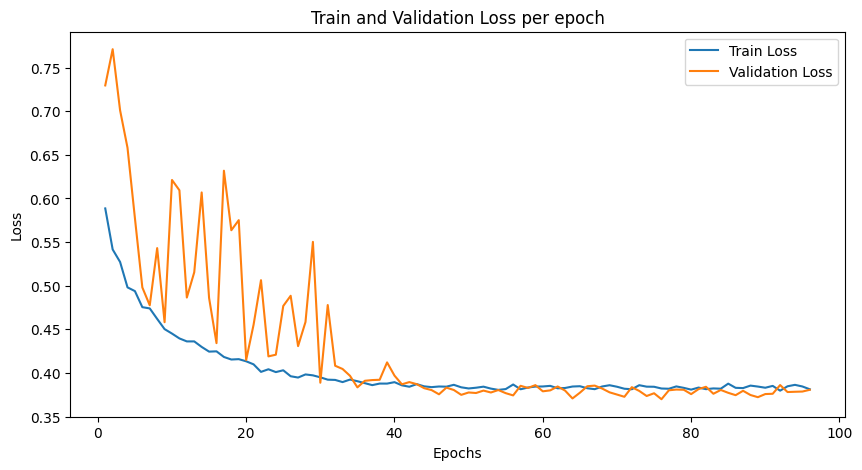

In [13]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(range(1, len(track_all_train_loss) + 1), track_all_train_loss, label='Train Loss')
plt.plot(range(1, len(track_all_val_loss) + 1), track_all_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss per epoch')
plt.legend()
plt.show()

In [14]:
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# model_weight_path = '/kaggle/input/resnet18_cbam_eca_69epoch/pytorch/default/1/best_model.pth'

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# net = ResNet18_CBAM_ECA().to(device)

# net.load_state_dict(torch.load(model_weight_path))
# print(net.load_state_dict(torch.load(model_weight_path)))


net.eval()
# Initialize an array to store filenames
true_negative_filenames = []
true = []
pre = []
proba = []

# DataLoader for the test dataset
batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset_f, batch_size=batch_size, shuffle=False, num_workers=0)

# Loop through the test dataset
for batch_idx, (images, labels) in enumerate(test_loader):
    # Get corresponding file paths for the current batch
    batch_image_paths = test_image_paths[batch_idx * batch_size:(batch_idx + 1) * batch_size]

    # Make predictions
    outputs = net(images.to(device))
    preds = outputs.argmax(dim=1, keepdim=True).cpu().numpy()
    test_probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()

    # Extend true labels, predictions, and probabilities
    true.extend(labels.cpu().numpy())
    pre.extend(preds)
    proba.extend(test_probs)

    # Save true positive filenames in the array
    for label, pred, img_path in zip(labels, preds, batch_image_paths):
        if label.item() == 1 and pred.item() == 1:
            original_name = os.path.basename(img_path)
            true_negative_filenames.append(original_name)

test_accuracy = accuracy_score(true, pre)
test_f1 = f1_score(true, pre)
test_roc = roc_auc_score(true, proba)
test_precision = precision_score(true, pre)
test_recall = recall_score(true, pre)

print(f"Test Accuracy: {test_accuracy}, Test F1: {test_f1}, Test ROC: {test_roc}, Test Precision: {test_precision}, Test Recall: {test_recall}")

true_negatives = sum((np.array(true) == 1) & (np.array(pre).flatten() == 1))
print(f"True Negatives (Predicted 1 when Ground Truth is 1): {true_negatives}")

# Output the list of true positive filenames
print(f"True negative filenames: {len(true_negative_filenames)}")

Test Accuracy: 0.9546971864568431, Test F1: 0.9685117666556181, Test ROC: 0.9853749460141387, Test Precision: 0.974, Test Recall: 0.9630850362557679
True Negatives (Predicted 1 when Ground Truth is 1): 1461
True negative filenames: 1461


In [15]:
# after 30 epochs
# Test Accuracy: 0.9518359561278016, Test F1: 0.9669610729473339, Test ROC: 0.983022299002114, Test Precision: 0.9597402597402598, Test Recall: 0.974291364535267
# True Negatives (Predicted 1 when Ground Truth is 1): 1478
# True negative filenames: 1478

# after 69 epochs
# Test Accuracy: 0.944206008583691, Test F1: 0.9606986899563319, Test ROC: 0.9855954356374877, Test Precision: 0.9794520547945206, Test Recall: 0.942649967040211
# True Negatives (Predicted 1 when Ground Truth is 1): 1430
# True negative filenames: 1430

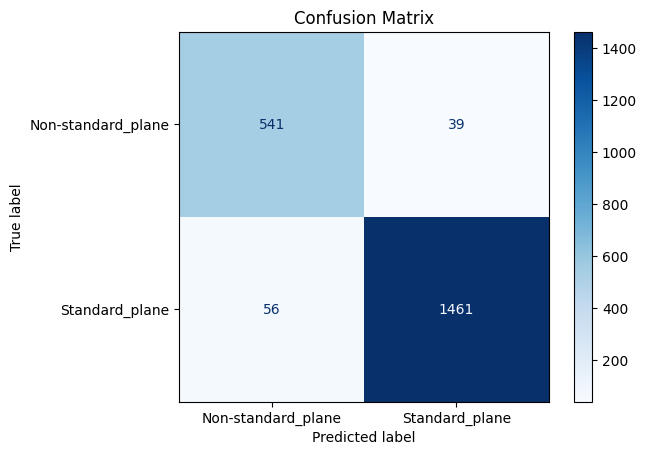

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true, pre)

# Plot the confusion matrix
class_labels = ['Non-standard_plane','Standard_plane']
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [17]:
# using traditonal method to calculate CI

# Import necessary libraries
import numpy as np
from scipy import stats

# Function to calculate 95% confidence interval for a parameter x
def calculate_confidence_interval(x, sample_size, confidence_level=0.95):
    # Calculate the standard error
    standard_error = np.sqrt((x * (1 - x)) / sample_size)

    # Find the Z-score for the given confidence level
    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

    # Calculate the margin of error
    margin_of_error = z_score * standard_error

    # Calculate the confidence interval
    lower_bound = x - margin_of_error
    upper_bound = x + margin_of_error

    return lower_bound, upper_bound

ci_lower, ci_upper = calculate_confidence_interval(test_accuracy, len(test_loader.dataset), confidence_level=0.95)
print(f"95% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})")

95% Confidence Interval: (0.9458, 0.9636)


In [18]:
# Bootstrapping AUCs to calculate CI

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

def bootstrap_auc(y_test, y_pred, n_iterations=2000, confidence_level=0.95):
    # Store the AUCs
    aucs = []
    n_size = len(y_test)

    for i in range(n_iterations):
        # print("Processing: ",i)
        # Resample the data with replacement
        y_test_resampled, y_pred_resampled = resample(y_test, y_pred, n_samples=n_size)
        # Calculate the AUC
        auc = roc_auc_score(y_test_resampled, y_pred_resampled)
        aucs.append(auc)

    # Calculate the lower and upper percentiles for the confidence interval
    lower_bound = np.percentile(aucs, ((1 - confidence_level) / 2) * 100)
    upper_bound = np.percentile(aucs, (confidence_level + ((1 - confidence_level) / 2)) * 100)

    return lower_bound, upper_bound, aucs


lower_ci, upper_ci, auc_scores = bootstrap_auc(true, pre)
print(f"Bootstrap AUC 95% CI: ({lower_ci:.3f}, {upper_ci:.3f})")

Bootstrap AUC 95% CI: (0.936, 0.959)


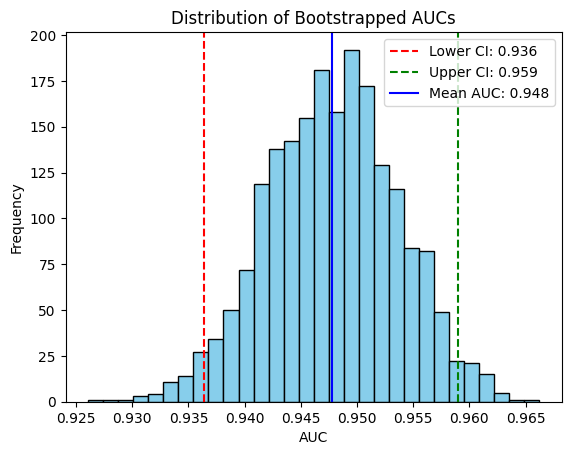

In [19]:
import matplotlib.pyplot as plt

plt.hist(auc_scores, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Bootstrapped AUCs')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.axvline(lower_ci, color='red', linestyle='--', label=f'Lower CI: {lower_ci:.3f}')
plt.axvline(upper_ci, color='green', linestyle='--', label=f'Upper CI: {upper_ci:.3f}')
plt.axvline(np.mean(auc_scores), color='blue', linestyle='-', label=f'Mean AUC: {np.mean(auc_scores):.3f}')
plt.legend()
plt.show()

In [20]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

def bootstrap_auc(y_test, y_pred, n_iterations=2000, confidence_level=0.95):
    """
    Bootstraps AUCs to calculate confidence intervals with stratification.

    Parameters:
    y_test: np.array or list
        True labels (binary classification).
    y_pred: np.array or list
        Predicted probabilities or scores.
    n_iterations: int
        Number of bootstrap iterations.
    confidence_level: float
        Confidence level for the CI.

    Returns:
    lower_bound: float
        Lower bound of the confidence interval.
    upper_bound: float
        Upper bound of the confidence interval.
    aucs: list
        List of AUCs from bootstrapping.
    """
    # Store the AUCs
    aucs = []
    n_size = len(y_test)

    for i in range(n_iterations):
        # Resample the data with replacement, ensuring at least one positive and one negative sample
        while True:
            y_test_resampled, y_pred_resampled = resample(y_test, y_pred, n_samples=n_size)
            if len(np.unique(y_test_resampled)) == 2:  # Check for both classes
                break

        # Calculate the AUC
        auc = roc_auc_score(y_test_resampled, y_pred_resampled)
        aucs.append(auc)

    # Calculate the lower and upper percentiles for the confidence interval
    lower_bound = np.percentile(aucs, ((1 - confidence_level) / 2) * 100)
    upper_bound = np.percentile(aucs, (confidence_level + ((1 - confidence_level) / 2)) * 100)

    return lower_bound, upper_bound, aucs

# Example usage:
# Replace true and pre with your actual data
# true = np.array([...])  # Binary ground truth
# pre = np.array([...])   # Predicted probabilities or scores

lower_ci, upper_ci, auc_scores = bootstrap_auc(true, pre)
print(f"Bootstrap AUC 95% CI: ({lower_ci:.3f}, {upper_ci:.3f})")

Bootstrap AUC 95% CI: (0.937, 0.959)
